In [1]:
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
from scipy.signal import find_peaks, savgol_filter
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress
# https://pypi.org/project/BaselineRemoval/
import BaselineRemoval

In [2]:
def read_data(path:str) -> tuple:
    wavenumbers = []
    values = []
    with open(path) as f:
        for line in f.readlines():
            wave, value = line.rstrip('\n').split('\t')
            wavenumbers.append(float(wave))
            values.append(float(value))
    return wavenumbers, values

def plot(wavenumbers, values, title="") -> None:
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
    for idx, value in enumerate(values):
        # print(value.shape)
        ax.plot(wavenumbers, value, label=idx)
    ax.grid()
    ax.set_title(f"A Raman Spectroscopy of {title}")
    ax.set_xlabel(f"wavenumber (cm^-1)")
    ax.set_ylabel(f"Intensity")
    ax.legend()
        # peak_idxs, _ = find_peaks(value, distance=100, height=value.mean())
        # for idxs in peak_idxs:
        #     x:float = wavenumbers[idxs] # type: ignore
        #     y:float = value[idxs] # type: ignore
        #     ax.axvline(x, color='black', linestyle='--', alpha=0.5)
        #     ax.text(x, y + 1, f'{x}')

    plt.show()

In [3]:
glucose_values = [121,137,145,150,139,126,122,126]

In [4]:
files = glob(f"./data/day3/*.txt")
wavenumbers = None
samples = []
dates = []
for file in files:
    wavenumbers, values = read_data(file)
    samples.append(np.array(values).reshape(1,-1))

    path, filename = os.path.split(file)
    # filename[-15:-7]
    date = datetime.strptime(filename[-15:-7], "%H_%M_%S")
    dates.append(date)

samples = np.vstack(samples)
wavenumbers = np.array(wavenumbers)
print(samples.shape)

(8, 1024)


In [5]:
# path, filename = os.path.split(files[0])
# filename[-15:-7]
# datetime.strptime(filename[-15:-7], "%H_%M_%S")

In [6]:
for sample in samples:
    print(sample.shape, wavenumbers.shape)

print(len(samples), len(wavenumbers), len(glucose_values))

(1024,) (1024,)
(1024,) (1024,)
(1024,) (1024,)
(1024,) (1024,)
(1024,) (1024,)
(1024,) (1024,)
(1024,) (1024,)
(1024,) (1024,)
8 1024 8


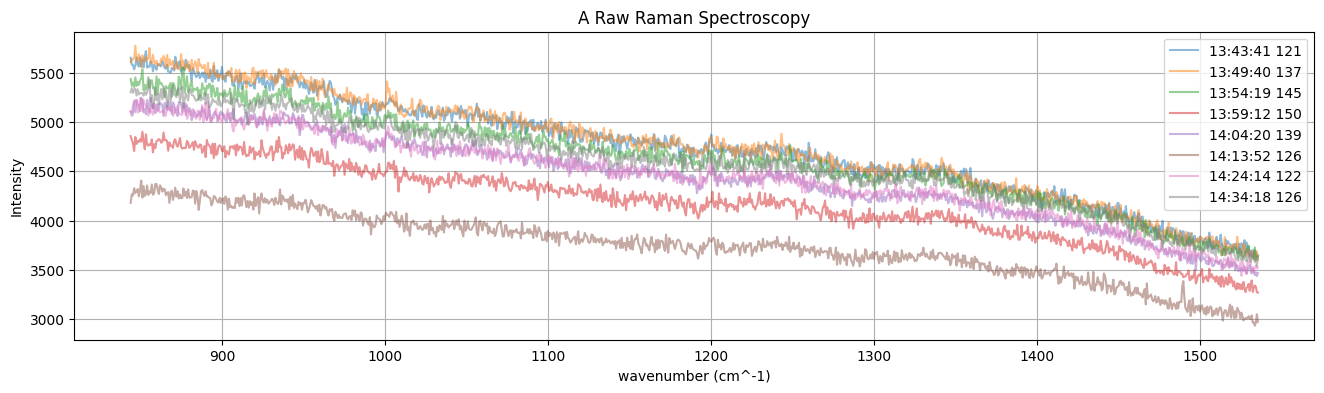

In [7]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
for i in range(8):
    ax.plot(wavenumbers, samples[i], label=f"{dates[i].strftime('%H:%M:%S')} {glucose_values[i]}", alpha=0.5)
ax.grid()
ax.set_title(f"A Raw Raman Spectroscopy")
ax.set_xlabel(f"wavenumber (cm^-1)")
ax.set_ylabel(f"Intensity")
ax.legend()
plt.show()

## Baseline Remove

In [8]:
from BaselineRemoval import BaselineRemoval

input_array=[10,20,1.5,5,2,9,99,25,47]

polynomial_degree=2 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(input_array)

Modpoly_output=baseObj.ModPoly(polynomial_degree)

Imodpoly_output=baseObj.IModPoly(polynomial_degree)

Zhangfit_output=baseObj.ZhangFit()

print('Original input:',input_array)

print('Modpoly base corrected values:',Modpoly_output)

print('IModPoly base corrected values:',Imodpoly_output)

print('ZhangFit base corrected values:',Zhangfit_output)

Original input: [10, 20, 1.5, 5, 2, 9, 99, 25, 47]
Modpoly base corrected values: [-1.98455800e-04  1.61793368e+01  1.08455179e+00  5.21544654e+00
  7.20210508e-02  2.15427531e+00  8.44622093e+01 -4.17691125e-03
  8.75511661e+00]
IModPoly base corrected values: [-0.84912125 15.13786196 -0.11351367  3.89675187 -1.33134142  0.70220645
 82.99739548 -1.44577432  7.37269705]
ZhangFit base corrected values: [ 8.49924691e+00  1.84994576e+01 -3.31739230e-04  3.49854060e+00
  4.97412948e-01  7.49628529e+00  9.74951576e+01  2.34940300e+01
  4.54929023e+01]


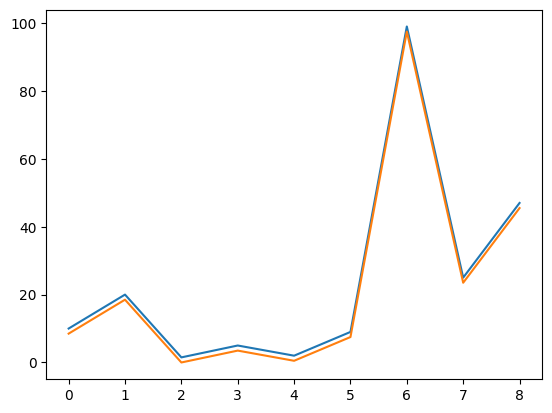

In [9]:
plt.plot(input_array)
plt.plot(Zhangfit_output)
# plt.plot(Modpoly_output)

In [10]:
def lin_fit(x,y,poly=2):
    lin = linregress(x**poly,y)
    # print(lin.rvalue)
    return lin.slope, lin.intercept

def normalized_slope(y, a,b, poly):
    return ((y - b) / a) ** (1/poly)

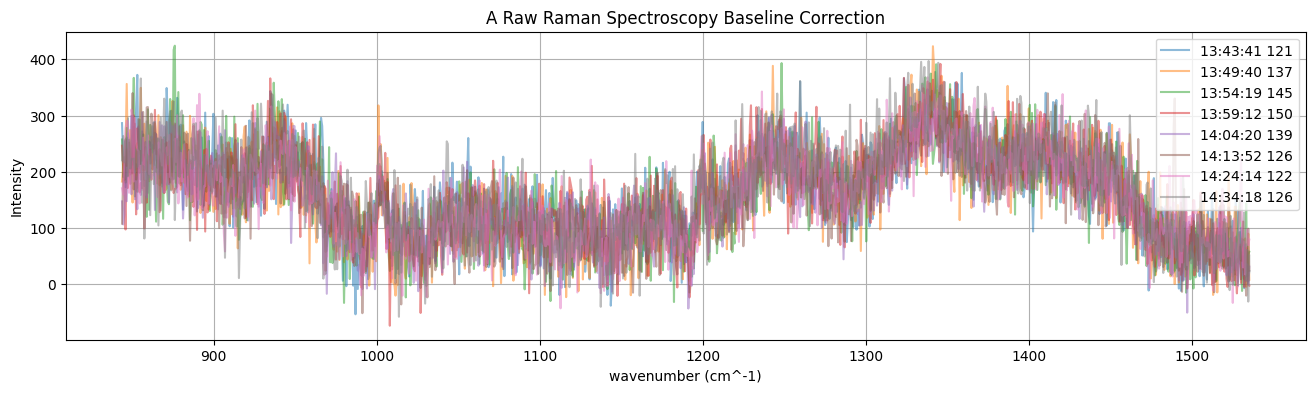

In [11]:
poly = 3
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
for i in range(8):
    removal = BaselineRemoval(samples[i])

    ax.plot(wavenumbers, removal.ModPoly(2), label=f"{dates[i].strftime('%H:%M:%S')} {glucose_values[i]}", alpha=0.5)
    # ax.plot(wavenumbers, samples[i], label=f"{dates[i].strftime('%H:%M:%S')} {glucose_values[i]}", alpha=0.5)
    # a,b = lin_fit(wavenumbers,samples[i],poly)
    # ax.plot(wavenumbers, normalized_slope(samples[i], a,b,poly), label=f"{dates[i].strftime('%H:%M:%S')} {glucose_values[i]}", alpha=0.5)
ax.grid()
ax.set_title(f"A Raw Raman Spectroscopy Baseline Correction")
ax.set_xlabel(f"wavenumber (cm^-1)")
ax.set_ylabel(f"Intensity")
ax.legend()
plt.show()

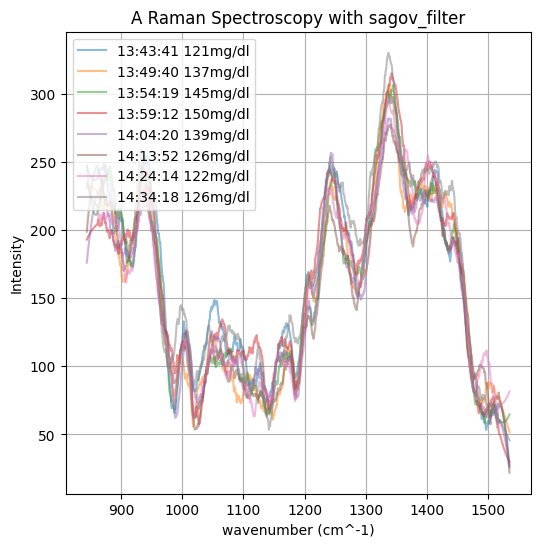

In [118]:
poly = 3
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,6))
correcteds = []
for i in range(8):
    removal = BaselineRemoval(samples[i])
    corrected = removal.ModPoly(2)
    sample = savgol_filter(corrected, window_length=50, polyorder=2)
    correcteds.append(sample)
    # sample = savgol_filter(samples[i], window_length=50, polyorder=10)
    ax.plot(wavenumbers, sample, label=f"{dates[i].strftime('%H:%M:%S')} {glucose_values[i]}mg/dl", alpha=0.5)
    # ax.plot(wavenumbers, sample, label=f"{i+1} {glucose_values[i]}mg/dl", alpha=0.8)
ax.grid()
ax.set_title(f"A Raman Spectroscopy with sagov_filter")
ax.set_xlabel(f"wavenumber (cm^-1)")
ax.set_ylabel(f"Intensity")
ax.legend()
plt.show()

Find peak

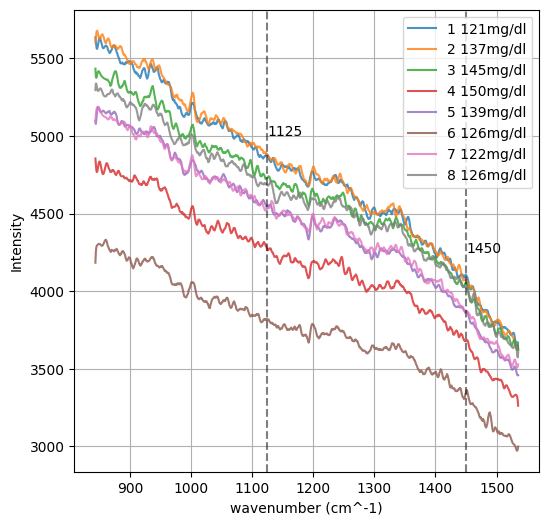

In [95]:
from scipy.signal import find_peaks

poly = 3
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,6))
for i in range(8):
    sample = savgol_filter(samples[i], window_length=50, polyorder=10)
    # ax.plot(wavenumbers, sample, label=f"{dates[i].strftime('%H:%M:%S')} {glucose_values[i]}mg/dl", alpha=0.5)
    # peak_idxs, _ = find_peaks(sample, distance=100, height=0, threshold=6)
    # for idxs in peak_idxs:
    #     x:float = wavenumbers[idxs] # type: ignore
    #     y:float = sample[idxs] # type: ignore
    #     ax.axvline(x, color='black', linestyle='--', alpha=0.5)
    #     ax.text(x, y + 1, f'{x}')
    ax.plot(wavenumbers, sample, label=f"{i+1} {glucose_values[i]}mg/dl", alpha=0.8)
ax.axvline(1125, color='black', linestyle='--', alpha=0.5)
ax.text(1125, 5000, f'1125')
ax.axvline(1450, color='black', linestyle='--', alpha=0.5)
ax.text(1450, 4250, f'1450')
ax.grid()
# ax.set_title(f"A Raman Spectroscopy with sagov_filter")
ax.set_xlabel(f"wavenumber (cm^-1)")
ax.set_ylabel(f"Intensity")
ax.legend()
plt.show()

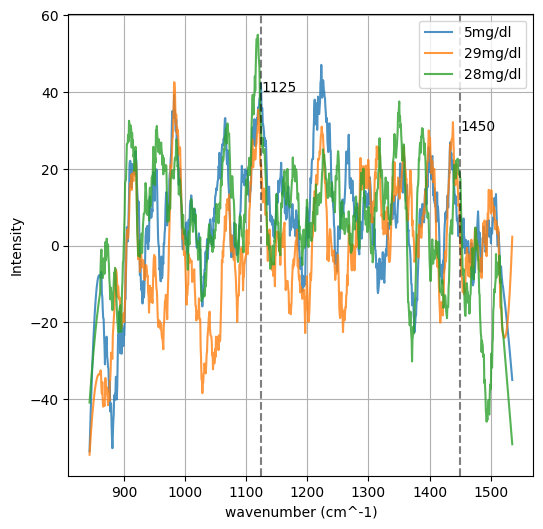

In [127]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,6))
ax.plot(wavenumbers, correcteds[3] - correcteds[2], label=f"{glucose_values[3] - glucose_values[2]}mg/dl", alpha=0.8)
ax.plot(wavenumbers, correcteds[3] - correcteds[0], label=f"{glucose_values[3] - glucose_values[0]}mg/dl", alpha=0.8)
ax.plot(wavenumbers, correcteds[3] - correcteds[6], label=f"{glucose_values[3] - glucose_values[6]}mg/dl", alpha=0.8)
ax.axvline(1125, color='black', linestyle='--', alpha=0.5)
ax.text(1125, 40, f'1125')
ax.axvline(1450, color='black', linestyle='--', alpha=0.5)
ax.text(1450, 30, f'1450')
ax.set_xlabel(f"wavenumber (cm^-1)")
ax.set_ylabel(f"Intensity")
ax.legend()
ax.grid()
plt.show()

0 1 16 -10.955915440812788
0 2 24 -11.106605101858236
0 3 29 16.831803855716316
0 4 18 -3.0816717327113565
0 5 5 -12.718083831258483
0 6 1 -11.6179187998938
0 7 5 -0.6298956068845456
1 2 8 -0.15068966104544756
1 3 13 27.787719296529104
1 4 2 7.874243708101432
1 5 11 1.7621683904456944
1 6 15 0.6620033590810124
1 7 11 -10.326019833928243
2 3 5 27.938408957574552
2 4 6 -8.02493336914688
2 5 19 1.6114787294002468
2 6 23 0.5113136980355648
2 7 19 -10.47670949497369
3 4 11 19.913475588427673
3 5 24 29.5498876869748
3 6 28 28.449722655610117
3 7 24 17.461699462600862
4 5 13 9.636412098547126
4 6 17 8.536247067182444
4 7 13 -2.451776125826811
5 6 4 -1.100165031364682
5 7 0 0
6 7 4 10.988023193009255


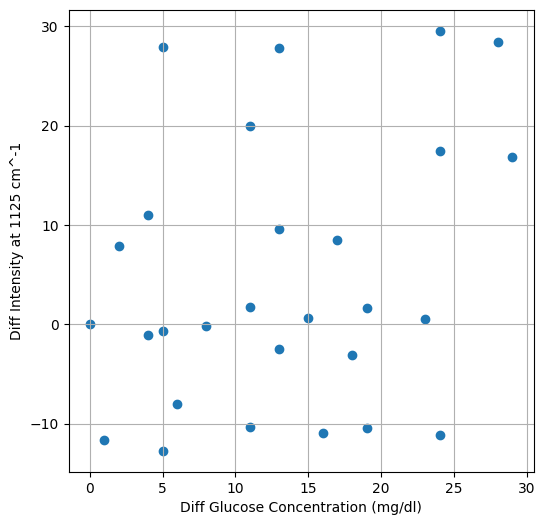

In [171]:
from itertools import combinations

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,6))
zoom_1125 = np.logical_and(wavenumbers >=1110, wavenumbers <=1140)
for idx_s1, idx_s2 in combinations(range(8), 2):
    sig_1 = correcteds[idx_s1][zoom_1125]
    sig_2 = correcteds[idx_s2][zoom_1125]
    glucose_1 = glucose_values[idx_s1]
    glucose_2 = glucose_values[idx_s2]
    
    diff_glucose = abs(glucose_1 - glucose_2)
    
    diff_sig = 0
    if(glucose_1 > glucose_2):
        diff_sig = np.mean(sig_1) - np.mean(sig_2)
    if(glucose_2 > glucose_1):
        diff_sig = np.mean(sig_2) - np.mean(sig_1)

    print(idx_s1, idx_s2, diff_glucose, diff_sig)
    # if(diff_sig <= 0): continue
    c = colors[0]
    ax.scatter(diff_glucose, diff_sig, c=c)
ax.set_xlabel(f"Diff Glucose Concentration (mg/dl)")
ax.set_ylabel(f"Diff Intensity at 1125 cm^-1")
# ax.legend()
ax.grid()
plt.show()

In [166]:

colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [86]:
zoom = np.logical_and(wavenumbers >= 1124.5, wavenumbers <= 1125.5)
np.where(zoom)[0][0]

400

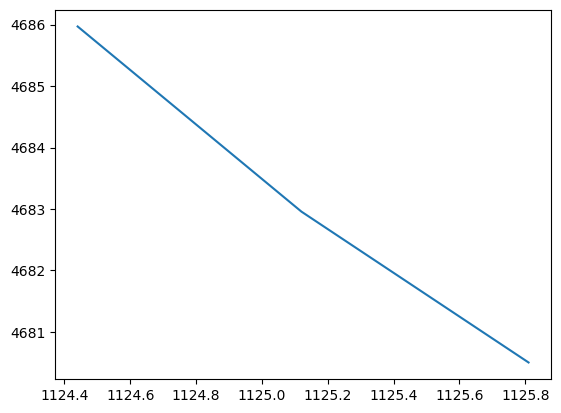

In [77]:
zoom = np.logical_and(wavenumbers >= 1124, wavenumbers <= 1126)
plt.plot(wavenumbers[zoom],sample[zoom])

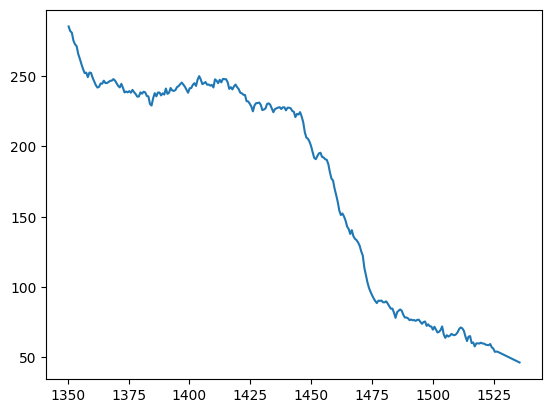

In [14]:
zoom = np.logical_and(wavenumbers >= 1350, wavenumbers <= 1550)
plt.plot(wavenumbers[zoom],sample[zoom])